In [12]:
from PIL import Image, ImageOps
import torch.nn.functional as F
import torch
from torch.utils.data import Dataset,DataLoader
from torchvision import transforms
from transformers import AutoImageProcessor, BertTokenizer, VisionEncoderDecoderModel,  ViTFeatureExtractor

In [13]:
import os

transpoop=transforms.PILToTensor()

def check_tensor_dimensions(tensor):
    if tensor.dim() != 3:
        return False

    if tensor.size(0) != 3:
        return False

    if tensor.size(1) <= 1 or tensor.size(2) <= 1:
        return False

    return True

DATA_INPUT_PATH = "/kaggle/input/iam-handwriting-word-database"

images_path = []
labels = []

def preprocess_dataset():
    characters = set()
    max_len = 0
    with open(os.path.join(DATA_INPUT_PATH, 'iam_words', 'words.txt'), 'r') as file:
        lines = file.readlines()

        for line_number, line in enumerate(lines):
            # Skip comments and empty lines
            if line.startswith('#') or line.strip() == '':
                continue

            # Split the line and extract information
            parts = line.strip().split()

            # Continue with the rest of the code
            word_id = parts[0]

            first_folder = word_id.split("-")[0]
            second_folder = first_folder + '-' + word_id.split("-")[1]

            # Construct the image filename
            image_filename = f"{word_id}.png"
            image_path = os.path.join(
                DATA_INPUT_PATH, 'iam_words', 'words', first_folder, second_folder, image_filename)

            # Check if the image file exists
            if os.path.isfile(image_path) and os.path.getsize(image_path):
                
                image2 = Image.open(image_path).convert("RGB")
                check = transpoop(image2)
                # print(check.shape)
                if check_tensor_dimensions(check)==True :
                    images_path.append(image_path)
                    # print("fuck me")
                    # Extract labels
                    label = parts[-1].strip()
                    for char in label:
                        characters.add(char)

                    max_len = max(max_len, len(label))
                    labels.append(label)
                    

    characters = sorted(list(characters))

    print('characters: ', characters)
    print('max_len: ', max_len)
    print(len(images_path))
#     # Mapping characters to integers.
#     char_to_num = tf.keras.layers.StringLookup(
#         vocabulary=list(characters), mask_token=None)

#     # Mapping integers back to original characters.
#     num_to_char = tf.keras.layers.StringLookup(
#         vocabulary=char_to_num.get_vocabulary(), mask_token=None, invert=True
#    )
    return characters, max_len # char_to_num, num_to_char, 
    
characters, max_len = preprocess_dataset()

characters:  ['!', '"', '#', "'", '(', ')', '*', ',', '-', '.', '/', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', ':', ';', '?', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']
max_len:  19
44531


In [14]:
# !pip install Pillow

In [15]:
image_processor = AutoImageProcessor.from_pretrained("microsoft/swin-base-patch4-window7-224-in22k")
# image_processor =  ViTFeatureExtractor(image_mean=[0.5],image_std=[0.5])
# image_processor =  ViTFeatureExtractor()
tokenizer = BertTokenizer.from_pretrained("google-bert/bert-base-uncased")

transpoop=transforms.PILToTensor()

def check_tensor_dimensions(tensor):
    if tensor.dim() != 3:
        return False, "The tensor is not 3-dimensional."

    if tensor.size(0) != 3:
        return False, "The first dimension is not 3."

    if tensor.size(1) <= 1 or tensor.size(2) <= 1:
        return False, "The second or third dimension is not greater than 1."

    return True, "The tensor has the correct dimensions."

def resize_with_padding(image, target_size):
    # Open an image file
    # with Image.open(image_path) as img:
    # Calculate the new size while maintaining the aspect ratio
    image.thumbnail(target_size, Image.ANTIALIAS)
        
    # Create a new image with the target size and a white background
    new_img = Image.new("RGB", target_size, (255, 255, 255))
        
    # Calculate the position to paste the resized image on the new image
    paste_position = ((target_size[0] - image.width) // 2,
                          (target_size[1] - image.height) // 2)
        
    # Paste the resized image onto the new image
    new_img.paste(image, paste_position)
        
    return new_img

def pad_to_size(tensor, desired_size=(1, 40), padding_value=0):
    
    current_size = tensor.size()
    
    # Check if the tensor already has the desired size
    if current_size == desired_size:
        return tensor
    
    # Calculate the padding needed
    pad_length = desired_size[1] - current_size[1]
    
    # Ensure the tensor is 2-dimensional (1, original_length)
    tensor = tensor.unsqueeze(0) if len(tensor.size()) == 1 else tensor
    
    # Apply padding
    padded_tensor = F.pad(tensor, (0, pad_length), 'constant', padding_value)
    
    return padded_tensor
    
class ImageTextDataset(Dataset):
    def __init__(self, image_paths, labels,processor,tokenizer):
        self.image_paths = image_paths
        self.labels = labels
        self.processor = processor
        self.tokenizer = tokenizer
#         self.transform = transform
#         self.target_transform = target_transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        image = Image.open(image_path).convert("RGB")
        label = self.labels[idx]
        
        
        pixel_values = self.processor(image, return_tensors="pt").pixel_values
        label = self.tokenizer(label, padding="max_length", max_length=128).input_ids
        
        label = [label1 if label1 != self.tokenizer.pad_token_id else -100 for label1 in label]

        encoding = {"pixel_values": pixel_values.squeeze(), "labels": torch.tensor(label)}
        return encoding
        
        
        # torch.tensor(label)
        
        # return image, label
    
# custom_transform = transforms.Compose([
#     transforms.Lambda(lambda img: resize_with_padding(image=img, target_size=(224, 224))),
#     transforms.Lambda(lambda img: image_processor(img, return_tensors="pt").pixel_values)
#     # transforms.ToTensor(),
#     # transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
# ])
    
# target_transform1=transforms.Compose([
#     transforms.Lambda(lambda lbl: tokenizer.encode(lbl,return_tensors="pt")),
#     transforms.Lambda(lambda ten: pad_to_size(ten))
# ])
dataset = ImageTextDataset(image_paths=images_path, labels=labels, processor=image_processor, tokenizer=tokenizer) # , transform=custom_transform, target_transform=target_transform1)
# dataloader = DataLoader(dataset, batch_size=12, shuffle=True, num_workers=4)

print("Number of training examples:", len(dataset))
for i in range(len(dataset)):
    check=dataset[i]

# Example usage
# resized_image = resize_with_padding("example.jpg", (300, 300))
# resized_image.show()
# resized_image.save("resized_with_padding.jpg")

Number of training examples: 44531


In [16]:
# tokenizer = BertTokenizer.from_pretrained("google-bert/bert-base-uncased")

# chlabels = tokenizer.encode(
#     "an image of two cats chilling on a couch",
#     return_tensors="pt",
#     padding=True,
#     max_length = 40
# )
# print("Labels shape:", chlabels.shape)

encoding = dataset[3]
for k,v in encoding.items():
  print(k, v.shape)

pixel_values torch.Size([3, 224, 224])
labels torch.Size([128])


In [17]:
# for batch_idx, (images, labels) in enumerate(dataloader):
#     print(f"Batch {batch_idx + 1}")
#     print("Images shape:", images.shape)
#     print("Labels shape:", labels.shape)
#     # print("Images:", images)
#     # print("Labels:", labels)
#     print("\n")
    
#     # Break after printing a few batches for inspection
#     if batch_idx == 1:
#         break

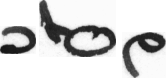

In [18]:
image1 = Image.open(images_path[3]).convert("RGB")
image1

In [19]:
label1 = encoding['labels']
label1[label1 == -100] = tokenizer.pad_token_id
label_str = tokenizer.decode(label1, skip_special_tokens=True)
print(label_str)

stop


In [20]:
model = VisionEncoderDecoderModel.from_encoder_decoder_pretrained(
    "microsoft/swin-base-patch4-window7-224-in22k", "google-bert/bert-base-uncased"
)
model.config.decoder_start_token_id = tokenizer.cls_token_id
model.config.pad_token_id = tokenizer.pad_token_id

# make sure vocab size is set correctly
model.config.vocab_size = model.config.decoder.vocab_size

# set beam search parameters
model.config.eos_token_id = tokenizer.sep_token_id
model.config.max_length = 64
model.config.early_stopping = True
model.config.no_repeat_ngram_size = 3
model.config.length_penalty = 2.0
model.config.num_beams = 4

config.json:   0%|          | 0.00/1.67M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/437M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertLMHeadModel were not initialized from the model checkpoint at google-bert/bert-base-uncased and are newly initialized: ['bert.encoder.layer.0.crossattention.output.LayerNorm.bias', 'bert.encoder.layer.0.crossattention.output.LayerNorm.weight', 'bert.encoder.layer.0.crossattention.output.dense.bias', 'bert.encoder.layer.0.crossattention.output.dense.weight', 'bert.encoder.layer.0.crossattention.self.key.bias', 'bert.encoder.layer.0.crossattention.self.key.weight', 'bert.encoder.layer.0.crossattention.self.query.bias', 'bert.encoder.layer.0.crossattention.self.query.weight', 'bert.encoder.layer.0.crossattention.self.value.bias', 'bert.encoder.layer.0.crossattention.self.value.weight', 'bert.encoder.layer.1.crossattention.output.LayerNorm.bias', 'bert.encoder.layer.1.crossattention.output.LayerNorm.weight', 'bert.encoder.layer.1.crossattention.output.dense.bias', 'bert.encoder.layer.1.crossattention.output.dense.weight', 'bert.encoder.layer.1.crossattention.self.key.bi

In [21]:
from transformers import Seq2SeqTrainer, Seq2SeqTrainingArguments

training_args = Seq2SeqTrainingArguments(
    predict_with_generate=True,
    evaluation_strategy="steps",
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    fp16=True, 
    output_dir="/kaggle/working/",
    logging_steps=2,
    save_steps=1000,
    eval_steps=200,
    save_total_limit=4,
    load_best_model_at_end=True,
    learning_rate = 3e-5,
    weight_decay = 0.01,
    warmup_steps = 500 
)

/opt/conda/lib/python3.10/site-packages/transformers/training_args.py:1474: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [22]:
!pip install jiwer

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 32.8 MB/s eta 0:00:00a 0:00:01


In [23]:
from datasets import load_metric

cer_metric = load_metric("cer")

/tmp/ipykernel_34/152175726.py:3: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  cer_metric = load_metric("cer")
/opt/conda/lib/python3.10/site-packages/datasets/load.py:759: FutureWarning: The repository for cer contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.19.2/metrics/cer/cer.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(


In [24]:
def compute_metrics(pred):
    labels_ids = pred.label_ids
    pred_ids = pred.predictions

    pred_str = tokenizer.batch_decode(pred_ids, skip_special_tokens=True)
    labels_ids[labels_ids == -100] = tokenizer.pad_token_id
    label_str = tokenizer.batch_decode(labels_ids, skip_special_tokens=True)

    cer = cer_metric.compute(predictions=pred_str, references=label_str)

    return {"cer": cer}

In [25]:
train_dataset, eval_dataset= torch.utils.data.random_split(dataset, (40078,4453 ))

In [26]:
print(len(train_dataset),' ',len(eval_dataset))

40078   4453


In [27]:
 !pip install wandb --upgrade

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


In [29]:
#from transformers import default_data_collator
from transformers import DefaultDataCollator
from transformers import  DataCollatorForSeq2Seq
from transformers import ViTFeatureExtractor

# default_data_collator= DataCollatorForSeq2Seq(tokenizer=tokenizer,model=model,padding='max_length',max_length=128)
default_data_collator= DefaultDataCollator()
# instantiate trainer
trainer = Seq2SeqTrainer(
    model=model,
    tokenizer=tokenizer,
    args=training_args,
    compute_metrics=compute_metrics,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    data_collator=default_data_collator,
)
trainer.train() 

Step,Training Loss,Validation Loss,Cer
200,2.407900,2.357545,0.806977
400,1.390300,2.312814,0.966826
600,1.812000,2.053372,0.773336
800,2.391900,1.980122,0.759007
1000,1.668200,1.916861,0.778009
1200,1.483100,1.847120,0.753245
1400,2.364600,1.803495,0.700602
1600,1.121000,1.728899,0.665559
1800,1.807700,1.674873,0.662652
2000,2.376600,1.590754,0.645104


Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 64, 'early_stopping': True, 'num_beams': 4, 'length_penalty': 2.0, 'no_repeat_ngram_size': 3}
Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 64, 'early_stopping': True, 'num_beams': 4, 'length_penalty': 2.0, 'no_repeat_ngram_size': 3}
Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.

TrainOutput(global_step=15030, training_loss=1.0450003768922793, metrics={'train_runtime': 21867.7554, 'train_samples_per_second': 5.498, 'train_steps_per_second': 0.687, 'total_flos': 2.188943199833061e+19, 'train_loss': 1.0450003768922793, 'epoch': 3.0})

In [36]:
from transformers import GenerationConfig
import requests
model = VisionEncoderDecoderModel.from_pretrained("/kaggle/working/checkpoint-15000")
generation_config = GenerationConfig.from_pretrained("/tmp", "/kaggle/working/checkpoint-15000/generation_config.json")
tokenizer = BertTokenizer.from_pretrained("google-bert/bert-base-uncased")
image_processor = AutoImageProcessor.from_pretrained("microsoft/swin-base-patch4-window7-224-in22k")
# url = "https://b2633864.smushcdn.com/2633864/wp-content/uploads/2020/08/ocr_handwriting_reco_adrian_sample.jpg?lossy=2&strip=1&webp=1"
image = Image.open("/kaggle/input/zauraiz/zauraiz.jpg").convert("RGB")
pixel_values = image_processor(image, return_tensors="pt").pixel_values
generated_ids = model.generate(pixel_values)
generated_text = tokenizer.batch_decode(generated_ids, skip_special_tokens=True)[0]
print(generated_text)

hebrew


In [ ]:
# image_processor = AutoImageProcessor.from_pretrained("microsoft/swin-base-patch4-window7-224-in22k")
# tokenizer = BertTokenizer.from_pretrained("google-bert/bert-base-uncased")
# dataset = load_dataset("huggingface/cats-image")
# image = dataset["test"]["image"][0]
# pixel_values = image_processor(image, return_tensors="pt").pixel_values

# labels = tokenizer(
#     "an image of two cats chilling on a couch",
#     return_tensors="pt",
# ).input_ids

# model.config.decoder_start_token_id = tokenizer.cls_token_id
# model.config.pad_token_id = tokenizer.pad_token_id

# # the forward function automatically creates the correct decoder_input_ids
# loss = model(pixel_values=pixel_values, labels=labels).loss